In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

## 데이터셋 소개

- **데이터셋 정보**
    - [예나 날씨 데이터](https://www.kaggle.com/datasets/mnassrib/jena-climate)
    - **2009년부터 2016년까지** 독일 예나 도시의 날씨 데이터를 10분 간격으로 기록.
    - **14개 칼럼**: 기온(°C), 기압(hPa), 습도(%), 바람 속도 등 다양한 정보 포함.

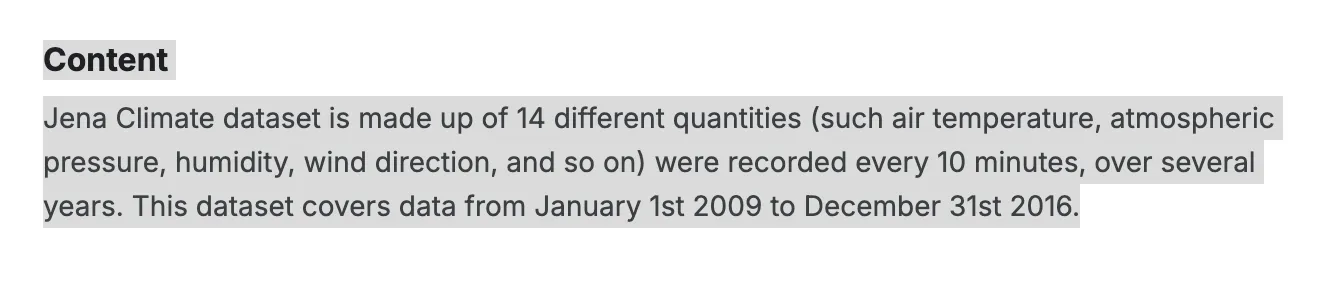  
- **예측 목표**
    - 주어진 길이의 **기온 시퀀스** 데이터를 활용해 **다음 시간의 기온**을 예측.

In [2]:
!wget https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-12-24 04:43:49--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.207, 172.217.218.207, 142.251.31.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  14.2MB/s    in 0.9s    

2025-12-24 04:43:51 (14.2 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


In [3]:
import pandas as pd

df = pd.read_csv("/content/jena_climate_2009_2016.csv")
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


- **칼럼 설명**
    - `Date Time`: 기록된 시간
    - `T (degC)`: 섭씨 온도
    - 기타 12개의 기상 요소 포함.

In [4]:
df.shape

(420551, 15)

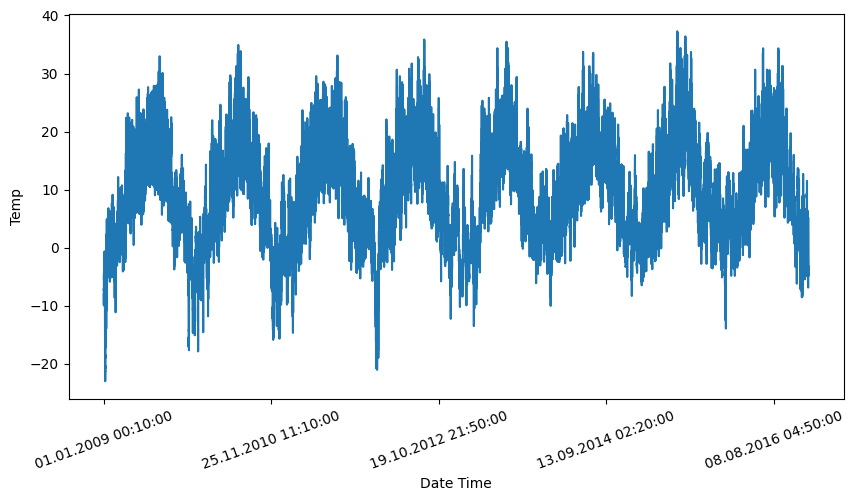

In [8]:
import matplotlib.pyplot as plt

temperatures = df['T (degC)']
temperatures.index = df['Date Time']

plt.figure(figsize=(10,5))
temperatures.plot()

plt.xticks(rotation=20)
plt.xlabel("Date Time")
plt.ylabel('Temp')
plt.show()

## 시계열 데이터 준비하기

In [10]:
import numpy as np

temperatures = df[['T (degC)']].to_numpy().astype(np.float32)
temperatures = temperatures[:50000]

데이터프레임에서 기온 데이터를 numpy array 형식으로 변환

기온 정보 하나만 가져오는 거지만, 데이터 자체는 2차원으로 유지(대괄호를 두 개씩)

- 2차원으로 유지해야 뒤에서 데이터 표준화를 할 때 문제가 없음

In [15]:
# train/val/test/ split

num_data = len(temperatures)

train_size = int(num_data * 0.8)
val_size = int(num_data * 0.1)

train_data = temperatures[:train_size]
val_data= temperatures[train_size : train_size + val_size]
test_data = temperatures[train_size + val_size : ]

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_data)

train_data_scaled = scaler.transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)


In [17]:
# 데이터 셋 만들기
import torch
from torch.utils.data import Dataset

class JenaTempDataset(Dataset):
    def __init__(self, temperatures, seq_len):
        self.temperatures = temperatures
        self.seq_len = seq_len

    def __len__(self):
        #원본 데이터 - 시퀀스 길이
        return len(self.temperatures) - self.seq_len

    def __getitem__(self, index):
        inputs = self.temperatures[index : index+self.seq_len]
        targets = self.temperatures[index+1 : index+self.seq_len + 1]

        return torch.tensor(inputs), torch.tensor(targets)

입력과 타깃 구조



- **입력**: 길이가 `sequence_length`인 시퀀스.
- **타깃**: 입력 데이터보다 한 타임스텝 뒤의 값.

 **예시**

```markdown

시퀀스 길이가 10이라면,
원본 시계열 데이터 : [t_0, t_1, t_2, ..., t_{N-1}]

**0번 데이터**
- Input:  [t_0, t_1, t_2, ..., t_9]
- Target: [t_1, t_2, t_3, ..., t_10]

**1번 데이터**
- Input:  [t_1, t_2, t_3, ..., t_10]
- Target: [t_2, t_3, t_4, ..., t_11]

```


- **입력**: 길이가 `sequence_length`인 시퀀스.
- **타깃**: 타임 스텝 하나의 데이터

 **예시**

```markdown

시퀀스 길이가 10이라면,
원본 시계열 데이터 : [t_0, t_1, t_2, ..., t_{N-1}]

**0번 데이터**
- Input:  [t_0, t_1, t_2, ..., t_9]
- Target: [t_10]

**1번 데이터**
- Input:  [t_1, t_2, t_3, ..., t_10]
- Target: [t_11]

```


In [22]:
# dataset

seq_len = 10
train_dataset = JenaTempDataset(train_data_scaled, seq_len)
val_dataset = JenaTempDataset(val_data_scaled, seq_len)
test_dataset  = JenaTempDataset(test_data_scaled, seq_len)

index=12
print(f"origin\n{train_data_scaled[index: index + seq_len+1]}")
print(f"inputs {index}\n{train_dataset[index][0]}\n")
print(f"targets {index}\n{train_dataset[index][1]}\n")

origin
[[-2.1951153]
 [-2.1928136]
 [-2.1732497]
 [-2.1732497]
 [-2.1778529]
 [-2.190512 ]
 [-2.1939645]
 [-2.2054725]
 [-2.2054725]
 [-2.196266 ]
 [-2.2112267]]
inputs 12
tensor([[-2.1951],
        [-2.1928],
        [-2.1732],
        [-2.1732],
        [-2.1779],
        [-2.1905],
        [-2.1940],
        [-2.2055],
        [-2.2055],
        [-2.1963]])

targets 12
tensor([[-2.1928],
        [-2.1732],
        [-2.1732],
        [-2.1779],
        [-2.1905],
        [-2.1940],
        [-2.2055],
        [-2.2055],
        [-2.1963],
        [-2.2112]])



In [23]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size= 128)
test_dataloader = DataLoader(test_dataset, batch_size= 128)

In [31]:
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1,
                            hidden_size=32,
                            num_layers=2,
                            batch_first=True
        )
        self.linear = nn.Linear(32, 1)

    def forward(self, x):
        lstm_output, _ = self.lstm(x)
        output = self.linear(lstm_output)
        # (b, seq_len, hidden_size) --> fc(hidden_size --> 1)
        return output

model = LSTMModel()

In [32]:
loss_fn = nn.MSELoss()
opt = optim.Adam(model.parameters())

In [34]:
#train loop

epochs = 5
step = 0

for epoch in range(epochs):
    model.train()
    for train_batch in train_dataloader:
        inputs = train_batch[0]
        targets = train_batch[1]

        preds = model(inputs)
        loss = loss_fn(preds, targets)

        loss.backward()
        opt.step()
        opt.zero_grad()

        step += 1
        if step % 100 == 0:
            print(f"step {step}, train loss : {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        losses = []
        for val_batch in val_dataloader:
            inputs = val_batch[0]
            targets = val_batch[1]
            preds = model(inputs)

            loss = loss_fn(preds, targets)
            losses.append(loss.item())
    val_loss_avg = sum(losses) / len(losses)
    print(f"\nepoch {epoch+1}/{epochs}, val loss : {val_loss_avg:.4f}\n")


step 100, train loss : 0.1261
step 200, train loss : 0.0513
step 300, train loss : 0.0182

epoch 1/5, val loss : 0.0054
step 400, train loss : 0.0056
step 500, train loss : 0.0031
step 600, train loss : 0.0019

epoch 2/5, val loss : 0.0008
step 700, train loss : 0.0016
step 800, train loss : 0.0014
step 900, train loss : 0.0021

epoch 3/5, val loss : 0.0007
step 1000, train loss : 0.0011
step 1100, train loss : 0.0011
step 1200, train loss : 0.0011

epoch 4/5, val loss : 0.0006
step 1300, train loss : 0.0013
step 1400, train loss : 0.0012
step 1500, train loss : 0.0013

epoch 5/5, val loss : 0.0005


In [35]:
#test set
test_preds = []
model.eval()
with torch.no_grad():
    for test_batch in test_dataloader:
        inputs = test_batch[0]
        preds = model(inputs)
        test_preds.append(preds[:, -1, :])

    test_preds = torch.cat(test_preds, dim=0)
    test_preds = test_preds.cpu().numpy()
    test_preds = scaler.inverse_transform(test_preds)

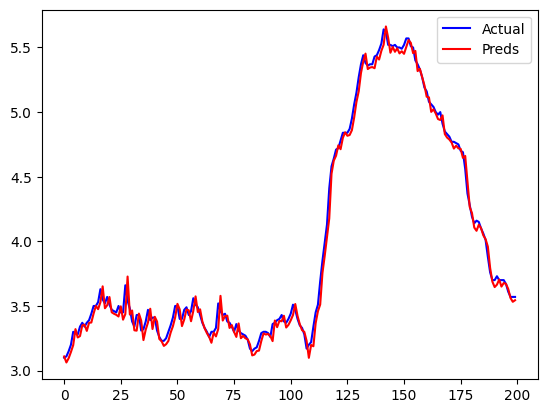

In [36]:
import matplotlib.pyplot as plt

test_targets = test_data[seq_len:]

plt.plot(test_targets[:200], color='blue', label='Actual')
plt.plot(test_preds[:200], color='red', label='Preds')
plt.legend()
plt.show()

## 삼성전자 주가 예측 (다변량 시계열)
### 학습 포인트

- 실제 데이터 연동: yfinance 라이브러리를 통해 실시간 데이터를 받아옵니다.

- 데이터 정규화(Normalization): 실제 데이터는 숫자의 단위가 매우 크기 때문에(수만 원, 수백만 주), 이를 0~1 사이로 줄여주는 MinMaxScaler가 필수적임을 배웁니다.

- 다변량 입력: 5개(시가, 고가, 저가, 종가, 거래량)의 특징을 보고 1개(종가)를 예측합니다.

In [38]:
!pip install yfinance -q

In [41]:
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler



In [42]:
stock_code = "005930.KS"
df = yf.download(stock_code, start="2020-01-01", end="2023-12-31")


/tmp/ipython-input-328766656.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_code, start="2020-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed


In [43]:
print(df.head())

Price              Close          High           Low          Open    Volume
Ticker         005930.KS     005930.KS     005930.KS     005930.KS 005930.KS
Date                                                                        
2020-01-02  47701.667969  48392.996490  47528.835838  47960.916164  12993228
2020-01-03  47960.910156  48911.486754  47442.413830  48392.990428  15422255
2020-01-06  47960.910156  48047.326211  47183.165667  47442.413830  10278951
2020-01-07  48220.167969  48738.664399  48047.335825  48133.751897  10009778
2020-01-08  49084.328125  49602.824549  48306.583489  48565.831701  23501171


In [44]:
data = df[['Open', 'High', 'Low', 'Close', 'Volume']].values
print(data.shape)


(985, 5)


In [46]:
# 데이터 정규화
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

data_scaled[:10,:]

array([[0.24876059, 0.21574759, 0.24746574, 0.24103562, 0.14387973],
       [0.25840234, 0.22614495, 0.24551706, 0.24672925, 0.17077741],
       [0.23719019, 0.20881582, 0.23967141, 0.24672925, 0.11382334],
       [0.25261742, 0.22267932, 0.25915712, 0.25242322, 0.11084267],
       [0.2622593 , 0.24000845, 0.26500276, 0.27140241, 0.2602388 ],
       [0.30468351, 0.26080332, 0.2942309 , 0.30556485, 0.26689845],
       [0.31239715, 0.27986548, 0.31176797, 0.32264625, 0.17717692],
       [0.32782404, 0.28506409, 0.32735623, 0.33213572, 0.12578474],
       [0.34325106, 0.30239323, 0.34294463, 0.33213572, 0.18721084],
       [0.32589549, 0.27813229, 0.32345896, 0.31315636, 0.15836046]])

In [49]:
# 데이터셋 생성
# 과거 30일의 5가지 지표를 보고 --> 다음날의 종가를 예측
def creat_dataset(data, seq_len):
    xs, ys =[], []
    for i in range(len(data)-seq_len):
        #입력 : 과거 30일치 모든 특징
        x_block = data[i: i+seq_len]

        #정답 : 다음날의 close 가격
        y_block = data[i+seq_len][3]

        xs.append(x_block)
        ys.append(y_block)
    return np.array(xs), np.array(ys)

seq_len = 30
X, Y = creat_dataset(data_scaled, seq_len)

print(X.shape, Y.shape)

(955, 30, 5) (955,)


In [51]:
train_size = int(len(X)*0.8)
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).unsqueeze(1)

print(X_train_tensor.size(), Y_train_tensor.size())
print(X_test_tensor.size(), Y_test_tensor.size())

torch.Size([764, 30, 5]) torch.Size([764, 1])
torch.Size([191, 30, 5]) torch.Size([191, 1])


In [52]:
class StockRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        last_out = out[:,-1,:]
        preds = self.fc(last_out)
        return preds

In [53]:
#하이퍼파라미터
input_size = 5 # Feature가 5개 (open, high, low, close, vol)
hidden_size = 64
output_size = 1
lr = 0.01
epochs = 100


In [54]:
model = StockRNN(input_size, hidden_size, output_size)
loss_fn = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=lr)


0/100, loss 0.0009
10/100, loss 0.0008
20/100, loss 0.0008
30/100, loss 0.0008
40/100, loss 0.0008
50/100, loss 0.0007
60/100, loss 0.0007
70/100, loss 0.0007
80/100, loss 0.0007
90/100, loss 0.0007


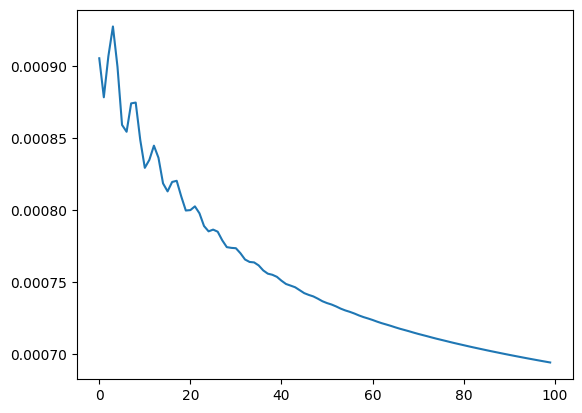

In [57]:
loss_hist = []
for i in range(epochs):
    outputs = model(X_train_tensor)
    loss = loss_fn(outputs, Y_train_tensor)
    loss.backward()
    opt.step()
    opt.zero_grad()

    loss_hist.append(loss.item())
    if i % 10 ==0:
        print(f"{i}/{epochs}, loss {loss.item():.4f}")

plt.plot(loss_hist)
plt.show()

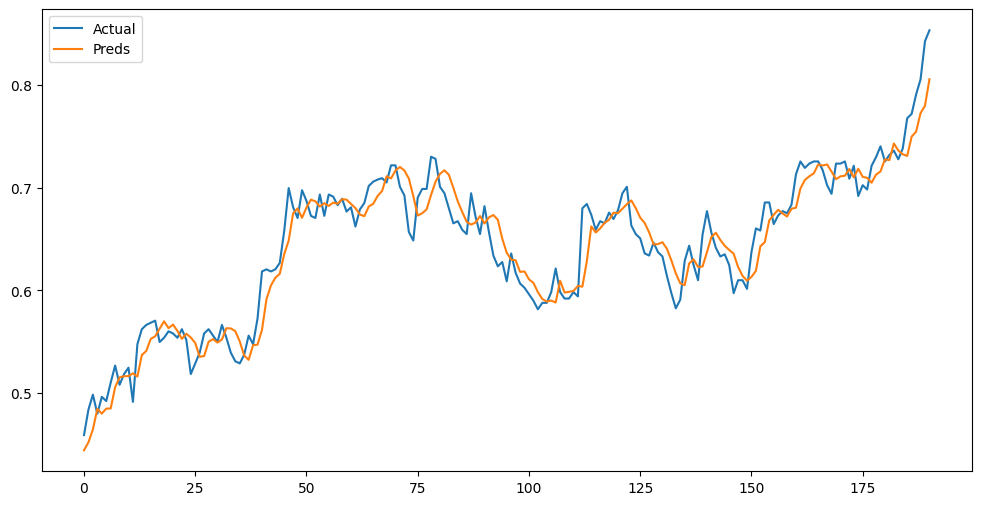

In [58]:
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor).numpy()

plt.figure(figsize=(12,6))
plt.plot(Y_test, label="Actual")
plt.plot(preds, label='Preds')
plt.legend()
plt.show()